ME4AI3 - Final Project (Oasis Longitudinal Dataset)

In [1]:
#Importing relevant libraries
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt

Reading the longitudinal MRI data

In [2]:
longitudinal_data = pd.read_csv(r"C:\MRI-Dementia-Pred\Longitudinal_Dataset\oasis_longitudinal.csv")
longitudinal_data.size

5595

Data cleaning and pre-processing

1. Remove all rows containing missing values
2. Convert Demented to 1, Nondemented to 0
3. Normalize MRI readings

In [3]:
longitudinal_data = longitudinal_data.dropna(axis=0)
longitudinal_data

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
5,OAS2_0004,OAS2_0004_MR1,Nondemented,1,0,F,R,88,18,3.0,28.0,0.0,1215,0.710,1.444
6,OAS2_0004,OAS2_0004_MR2,Nondemented,2,538,F,R,90,18,3.0,27.0,0.0,1200,0.718,1.462
7,OAS2_0005,OAS2_0005_MR1,Nondemented,1,0,M,R,80,12,4.0,28.0,0.0,1689,0.712,1.039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,OAS2_0185,OAS2_0185_MR2,Demented,2,842,M,R,82,16,1.0,28.0,0.5,1693,0.694,1.037
369,OAS2_0185,OAS2_0185_MR3,Demented,3,2297,M,R,86,16,1.0,26.0,0.5,1688,0.675,1.040
370,OAS2_0186,OAS2_0186_MR1,Nondemented,1,0,F,R,61,13,2.0,30.0,0.0,1319,0.801,1.331
371,OAS2_0186,OAS2_0186_MR2,Nondemented,2,763,F,R,63,13,2.0,30.0,0.0,1327,0.796,1.323


In [4]:
longitudinal_data["Group"].unique()

array(['Nondemented', 'Demented', 'Converted'], dtype=object)

This dataset contains two visits - for classification, replace all converted to demented. 

In [5]:
longitudinal_data["Group"] = longitudinal_data["Group"].replace("Converted", "Demented")
longitudinal_data["Group"].unique()

array(['Nondemented', 'Demented'], dtype=object)

Replace Demented with 1 and Non demented with 0

In [6]:
longitudinal_data["Group"] = longitudinal_data["Group"].replace({"Demented": 1, "Nondemented": 0})
longitudinal_data["Group"].unique()

array([0, 1], dtype=int64)

Apply min max normalization to the eTIV, nWBV, ASF

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
MRI_data = ["eTIV", "nWBV", "ASF"]

# Apply the scaler to the specified columns
longitudinal_data[MRI_data] = scaler.fit_transform(longitudinal_data[MRI_data])
longitudinal_data[MRI_data]

,eTIV,nWBV,ASF
0,0.981069,0.269430,0.009845
1,1.000000,0.191710,0.000000
5,0.121381,0.341969,0.798875
6,0.104677,0.383420,0.824191
7,0.649220,0.352332,0.229255
...,...,...,...
368,0.653675,0.259067,0.226442
369,0.648107,0.160622,0.230661
370,0.237194,0.813472,0.639944
371,0.246102,0.787565,0.628692


Visualizing the dataset

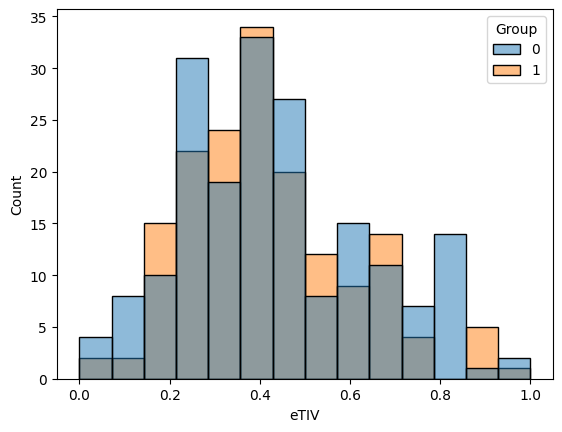

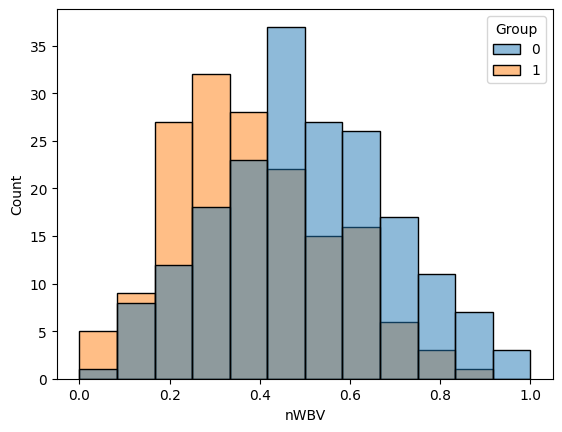

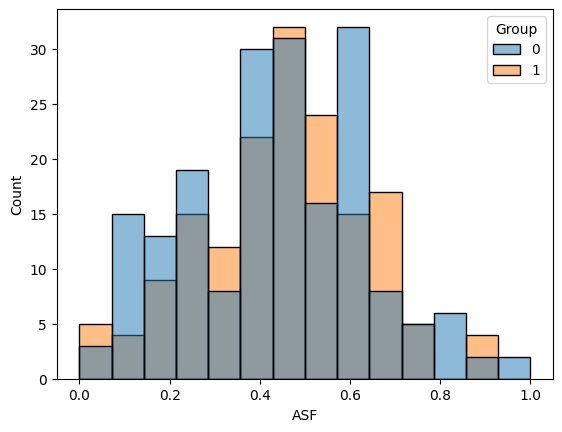

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=longitudinal_data, x="eTIV", hue="Group")
plt.show()
sns.histplot(data=longitudinal_data, x="nWBV", hue="Group")
plt.show()
sns.histplot(data=longitudinal_data, x="ASF", hue="Group")
plt.show()

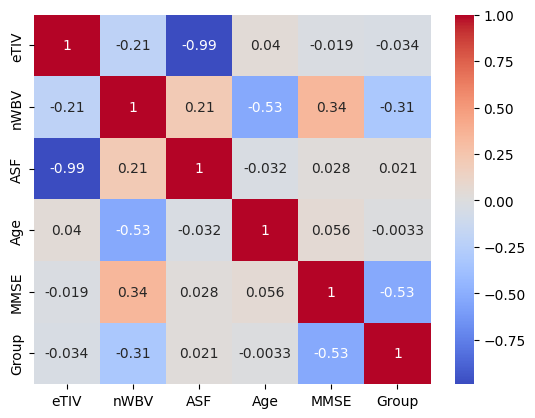

In [9]:
correlation_matrix = longitudinal_data[["eTIV", "nWBV", "ASF", "Age", "MMSE","Group"]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.show()

ASF and eTIV appear to be highly correlated

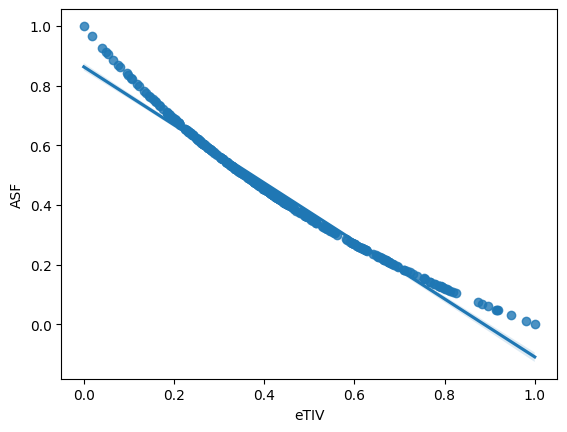

In [10]:
from scipy.stats import linregress


sns.regplot(x=longitudinal_data['eTIV'], y=longitudinal_data['ASF'])
plt.xlabel("eTIV")
plt.ylabel("ASF")
slope, intercept, r_value, p_value, std_err = linregress(longitudinal_data['eTIV'], longitudinal_data['ASF'])
r_squared = r_value**2

In [11]:
print(longitudinal_data['Group'].value_counts())

Group
0    190
1    164
Name: count, dtype: int64


Training Models

In [12]:
from sklearn.preprocessing import StandardScaler

Classification_params = ['eTIV', 'nWBV', 'ASF','Age','MMSE']
scaler = StandardScaler()
X = longitudinal_data[Classification_params]
X_scaled = scaler.fit_transform(X)  # This scales the data
y = longitudinal_data['Group']

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 1)

Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

#Base performance

model_LR = LogisticRegression(max_iter=1000,C=1,solver='lbfgs')
model_LR.fit(X_train, y_train)
y_predict = model_LR.predict(X_test)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.67      0.95      0.79        37
           1       0.89      0.50      0.64        34

    accuracy                           0.73        71
   macro avg       0.78      0.72      0.71        71
weighted avg       0.78      0.73      0.72        71



In [15]:
# Define parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100], #Regularization strength
    'solver': ['lbfgs', 'liblinear'],  
    'max_iter': [100, 500, 1000, 2000]
}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

#Evaluate most suitable parameters
print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_
y_predict = best_model.predict(X_test)
print(classification_report(y_test, y_predict))

Best Parameters: {'C': 1, 'max_iter': 100, 'solver': 'lbfgs'}
              precision    recall  f1-score   support

           0       0.67      0.95      0.79        37
           1       0.89      0.50      0.64        34

    accuracy                           0.73        71
   macro avg       0.78      0.72      0.71        71
weighted avg       0.78      0.73      0.72        71



In [16]:
from sklearn.model_selection import cross_val_score

# Example fixed hyperparameters
model_LR = LogisticRegression(C=1, solver='lbfgs', max_iter=100)

# 5-fold cross validation
cv_scores = cross_val_score(model_LR, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())

model_LR.fit(X_train, y_train)
y_predict = model_LR.predict(X_test)
print(classification_report(y_test, y_predict))

Cross-validation scores: [0.71929825 0.8245614  0.8245614  0.80357143 0.83928571]
Mean CV accuracy: 0.8022556390977444
              precision    recall  f1-score   support

           0       0.67      0.95      0.79        37
           1       0.89      0.50      0.64        34

    accuracy                           0.73        71
   macro avg       0.78      0.72      0.71        71
weighted avg       0.78      0.73      0.72        71



SVM

In [17]:
from sklearn.calibration import CalibratedClassifierCV # For probability score output
from sklearn.svm import LinearSVC

model_svc = LinearSVC(max_iter=100000)
model_svm = CalibratedClassifierCV(model_svc) 
model_svm.fit(X_train, y_train)

y_predict = model_svm.predict(X_test)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.67      0.95      0.79        37
           1       0.89      0.50      0.64        34

    accuracy                           0.73        71
   macro avg       0.78      0.72      0.71        71
weighted avg       0.78      0.73      0.72        71



c:\Users\ekuep\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\ekuep\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\ekuep\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\ekuep\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of 

In [18]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Define a parameter grid for LinearSVC
param_grid = {
    'estimator__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'estimator__max_iter': [1000, 5000, 10000, 50000],  # Max iterations
}

# Wrap LinearSVC in CalibratedClassifierCV
svc = LinearSVC(dual=False, max_iter=1000)
model = CalibratedClassifierCV(estimator=svc)

# Perform GridSearchCV on the wrapped model
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Evaluate the best parameters and performance
print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_
y_predict = best_model.predict(X_test)
print(classification_report(y_test, y_predict))



Best Parameters: {'estimator__C': 100, 'estimator__max_iter': 1000}
              precision    recall  f1-score   support

           0       0.67      0.95      0.79        37
           1       0.89      0.50      0.64        34

    accuracy                           0.73        71
   macro avg       0.78      0.72      0.71        71
weighted avg       0.78      0.73      0.72        71



Random Forest Classifier

In [19]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)
y_predict = model_rf.predict(X_test)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.68      0.73      0.70        37
           1       0.68      0.62      0.65        34

    accuracy                           0.68        71
   macro avg       0.68      0.67      0.67        71
weighted avg       0.68      0.68      0.67        71



In [20]:
# Define parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],  
    'max_depth': [10, 20, 30],         
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4],    
    'max_features': ['sqrt', 'log2', None],  
    'bootstrap': [True, False]   
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
best_rf_model = grid_search.best_estimator_
y_predict = best_rf_model.predict(X_test)
print(classification_report(y_test, y_predict))

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Best Parameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
              precision    recall  f1-score   support

           0       0.68      0.81      0.74        37
           1       0.74      0.59      0.66        34

    accuracy                           0.70        71
   macro avg       0.71      0.70      0.70        71
weighted avg       0.71      0.70      0.70        71



KNNs

In [21]:
from sklearn.neighbors import KNeighborsClassifier

model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)
X_test = np.asarray(X_test)
y_predict = model_knn.predict(X_test) 
print(classification_report(y_test, y_predict))


              precision    recall  f1-score   support

           0       0.78      0.76      0.77        37
           1       0.74      0.76      0.75        34

    accuracy                           0.76        71
   macro avg       0.76      0.76      0.76        71
weighted avg       0.76      0.76      0.76        71



In [22]:
param_grid = {
    'n_neighbors': [3, 5, 7, 10, 15],  
    'weights': ['uniform', 'distance'],  
    'metric': ['euclidean', 'manhattan', 'minkowski'],  
    'p': [1, 2] 
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
best_knn_model = grid_search.best_estimator_
y_predict = best_knn_model.predict(X_test)
print(classification_report(y_test, y_predict))

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best Parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

           0       0.75      0.73      0.74        37
           1       0.71      0.74      0.72        34

    accuracy                           0.73        71
   macro avg       0.73      0.73      0.73        71
weighted avg       0.73      0.73      0.73        71



Naive Bayes

In [23]:
from sklearn.naive_bayes import GaussianNB
model_gnb = GaussianNB()
model_gnb.fit(X_train, y_train)
y_predict = model_gnb.predict(X_test)

print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.69      0.97      0.81        37
           1       0.95      0.53      0.68        34

    accuracy                           0.76        71
   macro avg       0.82      0.75      0.74        71
weighted avg       0.81      0.76      0.75        71



In [24]:

param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]  # Range of values for the variance smoothing
}


gnb = GaussianNB()
grid_search = GridSearchCV(estimator=gnb, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
best_gnb_model = grid_search.best_estimator_
y_predict = best_gnb_model.predict(X_test)
print(classification_report(y_test, y_predict))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


Best Parameters: {'var_smoothing': 1e-09}
              precision    recall  f1-score   support

           0       0.69      0.97      0.81        37
           1       0.95      0.53      0.68        34

    accuracy                           0.76        71
   macro avg       0.82      0.75      0.74        71
weighted avg       0.81      0.76      0.75        71



In [25]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
model_XGB = xgb.XGBClassifier()
model_XGB.fit(X_train, y_train)
y_predict = model_XGB.predict(X_test)
print(classification_report(y_test, y_predict))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.70      0.70      0.70        37
           1       0.68      0.68      0.68        34

    accuracy                           0.69        71
   macro avg       0.69      0.69      0.69        71
weighted avg       0.69      0.69      0.69        71

Confusion Matrix:
 [[26 11]
 [11 23]]


In [26]:
# Define parameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200, 300], 
    'max_depth': [3, 6, 10],           
    'learning_rate': [0.01, 0.1, 0.2], 
    'subsample': [0.7, 0.8, 0.9], 
    'colsample_bytree': [0.7, 0.8, 1.0],  
    'gamma': [0, 0.1],            
}

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
best_xgb_model = grid_search.best_estimator_
y_predict = best_xgb_model.predict(X_test)
print(classification_report(y_test, y_predict))

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


c:\Users\ekuep\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:54:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.9}
              precision    recall  f1-score   support

           0       0.68      0.70      0.69        37
           1       0.67      0.65      0.66        34

    accuracy                           0.68        71
   macro avg       0.68      0.67      0.68        71
weighted avg       0.68      0.68      0.68        71

